In [1]:
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment',None)
pd.set_option('display.max_rows', None)

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
# Set date filters
avg_startdt = '2020-09-01'
bar_startdt = '2019-04-01'

# Import transaction datasets and set filter date
sp = pd.read_csv('Chase1_Activity.CSV')
fd = pd.read_csv('Chase2_Activity.CSV')
ae = pd.read_csv('Amex_activity.csv')
dc = pd.read_csv('Discover_Activity.csv')

In [3]:
# AMEX data cleaning & categorization
bc = ae[['Date','Description','Category','Amount']]
bc.rename(columns={'Date':'Transaction Date'},inplace=True)
bc.loc[:,'Type'] = 'Sale'
bc.loc[:,'Post Date'] = bc.loc[:,'Transaction Date']
bc.loc[:,'Amount'] = bc.loc[:,'Amount']*-1

bc.reset_index(inplace=True,drop=True)
m = bc['Description'].str.lower().str.contains('payment')
bc.drop(bc[m].index, axis=0, inplace=True)

for i in bc.index:
    word = bc.at[i, 'Category']
    bc.at[i, 'Category'] = word.split('-')[1]

bc.loc[:,'Card'] = 'AMEX'
m = bc['Amount']>0
bc.loc[m, 'Type'] = 'Credit'

In [4]:
# Discover data cleaning & categorization
dc.rename({'Trans. Date': 'Transaction Date'},axis=1,inplace=True)

mask = dc['Description'].str.lower().str.contains('payment|directpay full')
dc.drop(dc[mask].index, axis=0, inplace=True)

mask = dc['Amount']
dc.loc[:,'Amount'] = mask*-1
mask = dc['Amount']<0
dc.loc[mask, 'Type'] = 'Sale'
dc.loc[:, 'Card'] = 'Discover'

In [5]:
# Chase data cleaning & organization
sp.loc[:, 'Card'] = 'Sapphire'
fd.loc[:, 'Card'] = 'Freedom'
ch = pd.concat([sp,fd])
ch.drop('Memo',axis=1,inplace=True)
ch.reset_index(drop=True,inplace=True)

mask = ch['Description'].str.lower().str.contains('payment')
ch.drop(ch[mask].index, axis=0, inplace=True)

In [6]:
# Combine all cards
cc = pd.concat([ch,bc,dc])
cc.reset_index(drop=True,inplace=True)

In [7]:
def recategorize(df):
    desc = df['Description']
    amt = df['Amount']
    typ = []
    
    for i in desc.index:
        for word in desc.iloc[i].lower().split():
            if (word == 'veterinary') or (word == 'petsmart'):
                cc.at[i, 'Category'] = 'Pet'
            if (word == 'tmobile*auto'):
                cc.at[i, 'Category'] = 'Phone Services'
            if (word == 'suddenlink'):
                cc.at[i, 'Category'] = 'Internet Services'
        if amt.loc[i] > 0:
            typ.append('Credit')
        else:
            typ.append('Sale')
    nt = pd.DataFrame(typ,columns=['Type'])
    cc.loc[:,'Type'] = nt
    
    mask = cc['Description'].str.lower().str.contains('tx dps|uscis')
    cc.loc[mask, 'Category'] = 'Personal'
    mask = cc['Category'].str.lower().str.contains('government')
    cc.loc[mask, 'Category'] = 'Personal'   
    mask = cc['Category'].str.lower().str.contains('bar &|restaurants')
    cc.loc[mask, 'Category'] = 'Food & Drink'  
    mask = cc['Category'].str.lower().str.contains('home')
    cc.loc[mask, 'Category'] = 'Home & Dept Stores'    
    mask = cc['Category'].str.lower().str.contains('supermarkets')
    cc.loc[mask, 'Category'] = 'Groceries' 
    mask = cc['Category'].str.lower().str.contains('merchandise|clothing|electronics')
    cc.loc[mask, 'Category'] = 'Shopping'   
    mask = cc['Category'].str.lower().str.contains('credits')
    cc.loc[mask, 'Category'] = 'Fees & Adjustments'
    mask = cc['Category'].str.lower().str.contains('gas')
    cc.loc[mask, 'Category'] = 'Fuel'
    mask = cc['Category'].str.lower().str.contains('taxis')
    cc.loc[mask, 'Category'] = 'Travel' 
    mask = cc['Description'].str.lower().str.contains('walmart|wal-mart|target')
    cc.loc[mask, 'Category'] = 'Home & Dept Stores'
    mask = cc['Description'].str.lower().str.contains('parking')
    cc.loc[mask, 'Category'] = 'Travel'
    mask = cc['Description'].str.lower().str.contains('cinemark')
    cc.loc[mask, 'Category'] = 'Entertainment'
    mask = cc['Description'].str.lower().str.contains('cvs')
    cc.loc[mask, 'Category'] = 'Health & Wellness'
    mask = cc['Description'].str.lower().str.contains('vpn')
    cc.loc[mask, 'Category'] = 'Internet Services'
    mask = cc['Description'].str.lower().str.contains('vehicle|vehreg|mb of houston|lexus')
    cc.loc[mask, 'Category'] = 'Automotive'
recategorize(cc)

cc.loc[:,'Timestamp'] = pd.to_datetime(cc['Transaction Date'])
cc.loc[:,'Year'] = cc['Timestamp'].apply(lambda x: x.year)
cc.loc[:,'Month'] = cc['Timestamp'].apply(lambda x: x.strftime('%b'))

In [8]:
cc.sort_values(by='Timestamp',inplace=True)
month_order = cc[(cc['Timestamp']>='2020-01-01') & (cc['Timestamp']<='2020-12-31')]['Month'].unique()

In [9]:
pt_bytime = pd.pivot_table(cc[cc['Timestamp']>=avg_startdt],values='Amount',index=['Type','Category'],
                           columns=['Year','Month'],
                           aggfunc='sum', fill_value=0).reindex(columns=month_order,level=1)
pt_bytime.loc[('Credit Total',''),:] = pt_bytime.loc['Credit'].sum()
pt_bytime.loc[('Sale Total',''),:] = pt_bytime.loc['Sale'].sum()
pt_bytime.loc[('Grand Total',''),:] = pt_bytime.iloc[:(pt_bytime.shape[0]-2),:].sum()
pt_bytime.loc[:,('Total','')] = pt_bytime.sum(axis=1)
pt_bytime.loc[:,('Monthly Avg','')] = pt_bytime.iloc[:,:pt_bytime.shape[1]-1].mean(axis=1).round(2)

In [10]:
cond = (pt_bytime.index == ('Credit Total', '')) | (pt_bytime.index == ('Sale Total', '')) | (pt_bytime.index == ('Grand Total', ''))
excl = pt_bytime[cond]
incl = pt_bytime[~cond]
sorted = incl.sort_values('Total')
pd.concat([sorted,excl])

Year                                2020                                2021  \
Month                                Sep      Oct      Nov      Dec      Jan   
Type         Category                                                          
Sale         Food & Drink        -420.71  -556.55  -565.31  -508.73  -557.56   
             Pet                 -331.70  -141.90  -191.12   -72.93  -873.08   
             Groceries           -280.10  -215.05  -281.37  -153.84  -364.54   
             Shopping             -77.79  -226.95  -536.39  -492.41  -258.10   
             Travel                 0.00   -52.97   -61.93  -148.26  -813.89   
             Health & Wellness      0.00     0.00  -739.43   -59.48     0.00   
             Phone Services      -128.83  -128.83  -128.84  -128.84  -128.84   
             Fuel                 -96.76  -115.13   -83.58  -183.13  -165.16   
             Bills & Utilities   -123.60  -109.12  -107.36   -97.23   -96.63   
             Insurance Services  -104.28  -104.28   -90.76   -90.76   -90.76   
             Internet Services    -80.60   -80.55   -80.55   -95.55  -121.89   
             Personal             -54.72  -176.63   -23.28     0.00     0.00   
             Home & Dept Stores   -16.34   -19.05   -21.91   -62.41  -153.82   
             Entertainment          0.00   -44.92     0.00     0.00     0.00   
             Education              0.00     0.00     0.00     0.00   -34.62   
             Automotive             0.00     0.00    -5.40     0.00   -12.98   
             Fees & Adjustments     0.00     0.00     0.00     0.00    -0.47   
Credit       Personal               0.00     8.00     0.00     0.00     0.00   
             Internet Services      0.00     0.00     0.00     0.00     0.00   
             Shopping               0.00     0.00     0.00    82.23     0.00   
             Fees & Adjustments    35.69     0.00     0.00     0.01   234.83   
Credit Total                       35.69     8.00     0.00    82.24   234.83   
Sale Total                      -1715.43 -1971.93 -2917.23 -2093.57 -3672.34   
Grand Total                     -1679.74 -1963.93 -2917.23 -2011.33 -3437.51   

Year                                         Total Monthly Avg  
Month                                Feb                        
Type         Category                                           
Sale         Food & Drink        -334.79  -2943.65     -490.61  
             Pet                 -141.90  -1752.63     -292.10  
             Groceries           -344.76  -1639.66     -273.28  
             Shopping             -28.65  -1620.29     -270.05  
             Travel                 0.00  -1077.05     -179.51  
             Health & Wellness      0.00   -798.91     -133.15  
             Phone Services      -128.91   -773.09     -128.85  
             Fuel                 -61.19   -704.95     -117.49  
             Bills & Utilities    -97.95   -631.89     -105.32  
             Insurance Services   -90.76   -571.60      -95.27  
             Internet Services   -100.69   -559.83      -93.30  
             Personal             -63.00   -317.63      -52.94  
             Home & Dept Stores     0.00   -273.53      -45.59  
             Entertainment          0.00    -44.92       -7.49  
             Education              0.00    -34.62       -5.77  
             Automotive             0.00    -18.38       -3.06  
             Fees & Adjustments     0.00     -0.47       -0.08  
Credit       Personal               0.00      8.00        1.33  
             Internet Services      9.58      9.58        1.60  
             Shopping               0.00     82.23       13.70  
             Fees & Adjustments     0.00    270.53       45.09  
Credit Total                        9.58    370.34       61.72  
Sale Total                      -1392.60 -13763.10    -2293.85  
Grand Total                     -1383.02 -13392.76    -2232.13

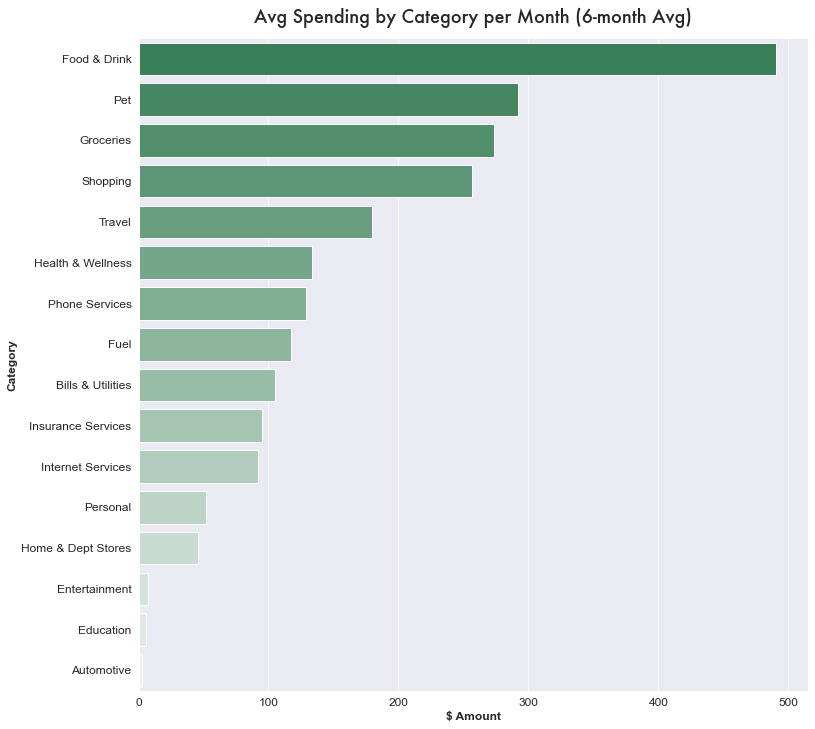

In [11]:
sns.set_style('darkgrid')
cmap = sns.light_palette('seagreen', reverse=True,
                             n_colors=len(cc[cc['Timestamp']>=avg_startdt].groupby('Category')[['Amount']].sum().sort_values('Amount').index[:-1]))
plt.figure(figsize=(12,12))
plt.rcParams.update({'font.size': 12})
sns.barplot(y=cc[cc['Timestamp']>=avg_startdt].groupby('Category')[['Amount']].sum().sort_values('Amount').index[:-1], 
            x=cc[cc['Timestamp']>=avg_startdt].groupby('Category')[['Amount']].sum().sort_values('Amount').iloc[:-1,0]*-1/(len(pt_bytime.columns[:-2])),
            palette = cmap, edgecolor=None)
plt.xlabel('$ Amount', fontweight='bold')
plt.ylabel('Category', fontweight='bold')
plt.title('Avg Spending by Category per Month (6-month Avg)', pad=16, font='Futura', size=18)
plt.show()

In [12]:
consume_bymonth = pd.pivot_table(cc[(cc['Timestamp']>=bar_startdt) & (cc['Category'].str.contains('Food &|Groceries'))],values='Amount',
                              index=['Year','Month','Category'],
                              aggfunc='sum', fill_value=0).reindex(index=month_order,level=1)
sumfd = consume_bymonth.reset_index()
sumfd['Month-Year'] = sumfd['Month']+'-'+sumfd['Year'].apply(str)
sumfd['Amount'] = sumfd['Amount'].apply(np.absolute)

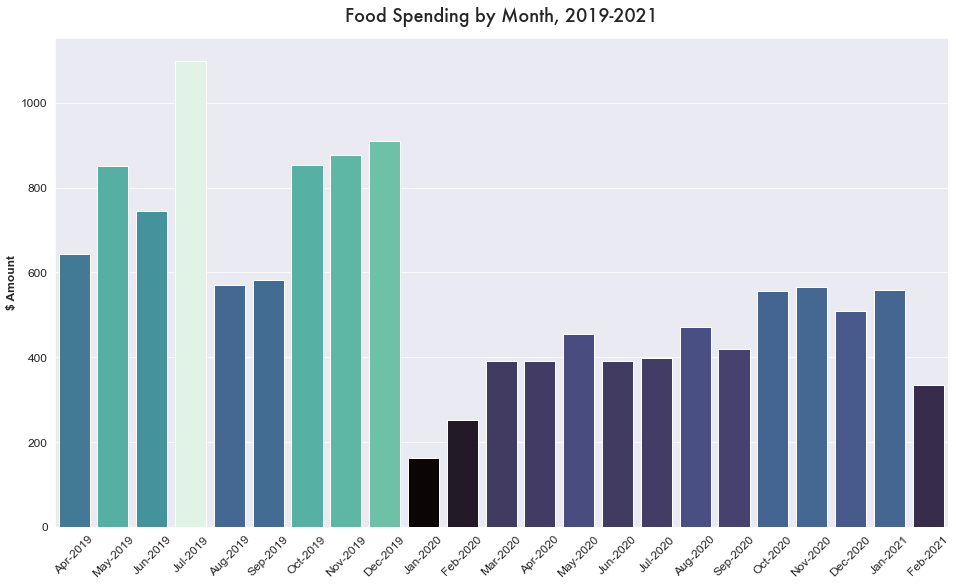

In [13]:
plt.figure(figsize=(16,9))
norm = plt.Normalize(sumfd[sumfd['Category'].str.contains('Food')]['Amount'].min(), 
                     sumfd[sumfd['Category'].str.contains('Food')]['Amount'].max())
cmap = plt.get_cmap('mako')
sns.barplot(y=sumfd[sumfd['Category'].str.contains('Food')]['Amount'],
            x=sumfd['Month-Year'],
            palette=cmap(norm(sumfd[sumfd['Category'].str.contains('Food')]['Amount'].values)))
plt.xticks(rotation=45)
plt.ylabel('$ Amount', fontweight='bold')
plt.xlabel('')
plt.title('Food Spending by Month, 2019-2021', pad=16, font='Futura', size=18)
plt.show()

In [14]:
consume_bymonth = pd.pivot_table(cc[(cc['Timestamp']>=bar_startdt) & (cc['Category'].str.contains('Food &|Groceries'))],values='Amount',
                              index=['Year','Month'], columns=['Category'],
                              aggfunc='sum', fill_value=0).reindex(index=month_order,level=1)

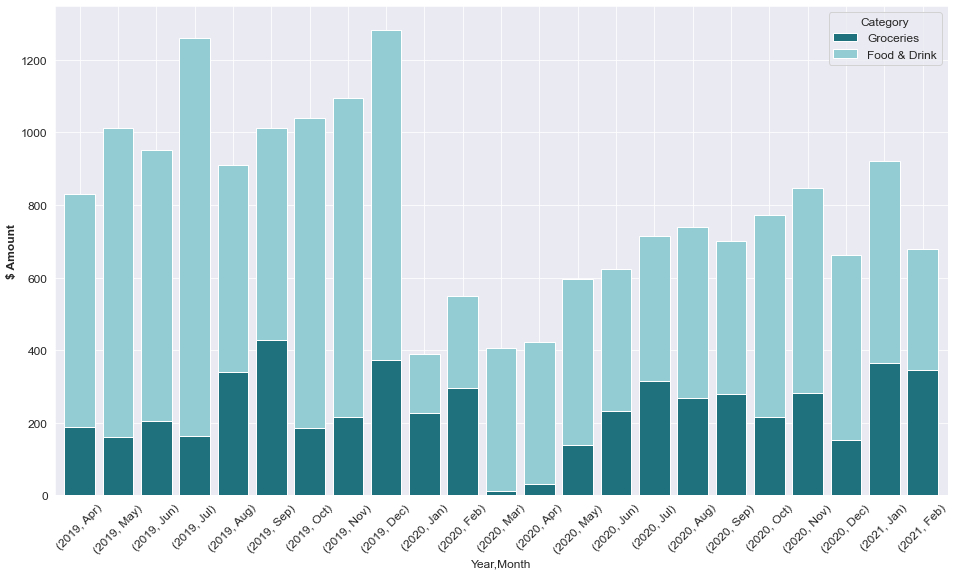

In [15]:
#Breakdown of grocery purchases vs eating out
consume_bymonth = consume_bymonth.apply(np.absolute)
consume_bymonth.loc[:,['Groceries','Food & Drink']].plot.bar(stacked=True,width=0.8,color=['#1f717d','#94ccd4'],
                                                             figsize=(16,9))
plt.xticks(rotation=45)
plt.ylabel('$ Amount', fontweight='bold')
plt.show()

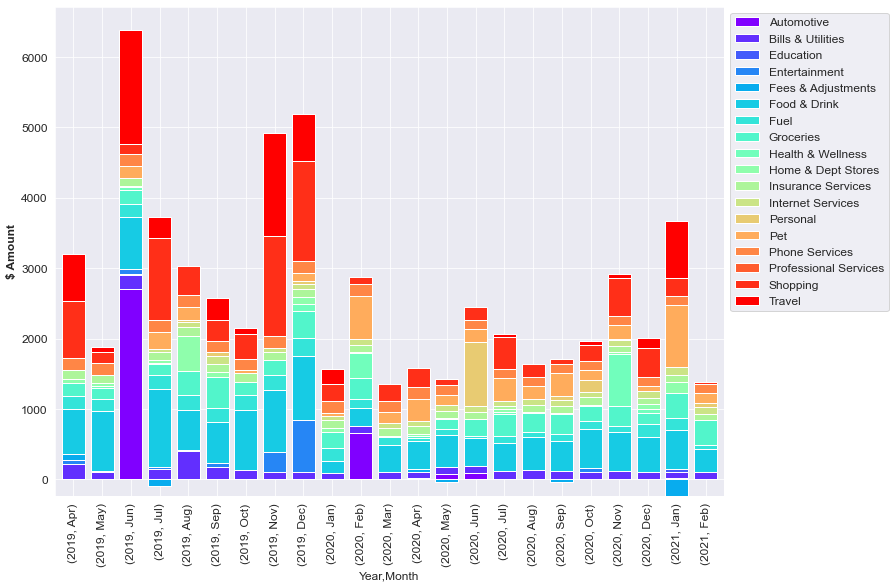

In [16]:
total_bymonth = pd.pivot_table(cc[(cc['Timestamp']>=bar_startdt)],values='Amount',
                              index=['Year','Month'], columns=['Category'],
                              aggfunc='sum', fill_value=0).reindex(index=month_order,level=1)
total_bymonth = total_bymonth.apply(np.negative)
total_bymonth.iloc[:,:].plot.bar(stacked=True,width=0.8,cmap='rainbow',figsize=(12,9),legend=True)
plt.xticks(rotation=90)
plt.ylabel('$ Amount', fontweight='bold')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()